<a href="https://colab.research.google.com/github/vishnuaravindan02/BrainTumorDetModel/blob/main/BrainTumorHybridDetModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import the necessary** **packages**

In [1]:
import os
import shutil
import glob

import warnings
warnings.filterwarnings('ignore')

#**Mount google drive and create a folder called "mri datasets"**

In [2]:
google_drive_path = '/content/drive/MyDrive/Colab Notebooks'

folder_name = 'mri_datasets'

folder_path = os.path.join(google_drive_path, folder_name)

os.makedirs(folder_path, exist_ok=True)

#**Unzip the zip file and extract it to the folder**

In [4]:
import zipfile

zip_file = '/content/drive/MyDrive/Colab Notebooks/BrainTumorDS.zip'

zip_file_path = os.path.join('/content/drive/MyDrive', '/content/drive/MyDrive/Colab Notebooks/BrainTumorDS.zip')

extracted_folder_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/mri_datasets')

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# **No of images in the directory**

In [5]:
ROOT_DIR = "/content/drive/MyDrive/Colab Notebooks/mri_datasets/Brain Tumor Data Set/Brain Tumor Data Set"
no_of_images = {}

for dir in os.listdir(ROOT_DIR):
  no_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

In [6]:
no_of_images.items()

dict_items([('Brain Tumor', 2513), ('Healthy', 2087)])

# **Sequencing the images of Tumor and Healthy images**

In [18]:
import os
import cv2
import numpy as np


tumorous_folder = '/content/drive/MyDrive/Colab Notebooks/mri_datasets/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'


healthy_folder = '/content/drive/MyDrive/Colab Notebooks/mri_datasets/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'


target_sequence_length = 5
image_size = (128, 128)


def load_and_preprocess_images(image_folder, sequence_length):
    image_sequences = []
    for root, dirs, files in os.walk(image_folder):
        image_sequence = []
        for filename in sorted(files):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                image_path = os.path.join(root, filename)
                image = cv2.imread(image_path)
                image = cv2.resize(image, image_size)
                image = image.astype(np.float32) / 255.0
                image_sequence.append(image)
                if len(image_sequence) == sequence_length:
                    image_sequences.append(np.array(image_sequence))
                    image_sequence = []

        if len(image_sequence) < sequence_length:

            num_blank_images = sequence_length - len(image_sequence)
            blank_image = np.zeros_like(image)

            for _ in range(num_blank_images):
                image_sequence.append(blank_image)

            image_sequences.append(np.array(image_sequence))
    return np.array(image_sequences)


tumorous_sequences = load_and_preprocess_images(tumorous_folder, target_sequence_length)
healthy_sequences = load_and_preprocess_images(healthy_folder, target_sequence_length)


print("Tumorous sequences shape:", tumorous_sequences.shape)
print("Healthy sequences shape:", healthy_sequences.shape)


Tumorous sequences shape: (472, 5, 128, 128, 3)
Healthy sequences shape: (416, 5, 128, 128, 3)


# **Displaying the images present in a particular sequence**

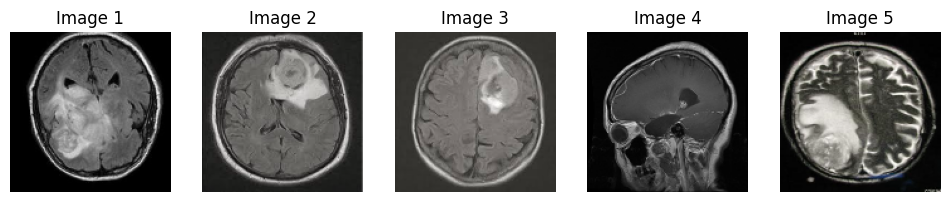

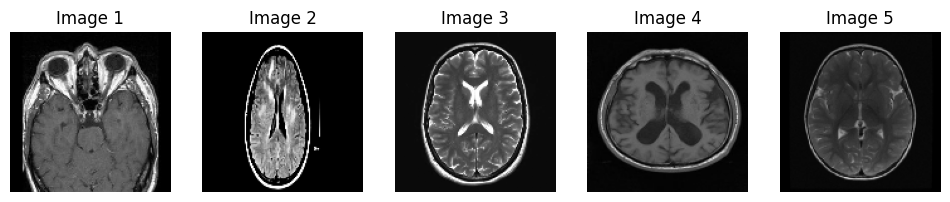

In [20]:
import matplotlib.pyplot as plt

# Function to display a sequence of images
def display_sequence(sequence):
    plt.figure(figsize=(12, 3))
    num_images = len(sequence)
    for i, image in enumerate(sequence):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f'Image {i + 1}')
        plt.axis('off')
    plt.show()

# Display the first sequence of tumorous images
tumorous_sequence = tumorous_sequences[2]
display_sequence(tumorous_sequence)

# Display the first sequence of healthy images
healthy_sequence = healthy_sequences[0]
display_sequence(healthy_sequence)


# **Splitting the given mri images to Train,Test and Validate**

In [21]:
from sklearn.model_selection import train_test_split

# Define the features (sequences) and labels for both classes
X = np.concatenate((tumorous_sequences, healthy_sequences), axis=0)  # Combine sequences
y = np.concatenate((np.ones(len(tumorous_sequences)), np.zeros(len(healthy_sequences))), axis=0)  # Labels

# Split the data into training, validation, and test sets
# You can adjust the test_size and random_state parameters as needed
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting sets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)


Training set shape: (710, 5, 128, 128, 3)
Validation set shape: (89, 5, 128, 128, 3)
Test set shape: (89, 5, 128, 128, 3)


# **Hybrid CNN-RNN model building**



In [22]:
# Create a Sequential model
model = Sequential()

# Add Convolutional layers with TimeDistributed
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(sequence_length,) + image_size + (3,)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

# Add Recurrent layers (LSTM)
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDis  (None, 5, 126, 126, 32)  896       
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 5, 63, 63, 32)    0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 5, 61, 61, 64)    18496     
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 5, 30, 30, 64)    0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 5, 57600)        

# **Training the Hybrid Model**

In [23]:
hs = model.fit(
    X_train,
    y_train,
    epochs=10,  # Adjust the number of epochs
    batch_size=32,  # Adjust the batch size
    validation_data=(X_val, y_val),
    verbose=2,
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
23/23 - 146s - loss: 0.6045 - accuracy: 0.6732 - val_loss: 0.3895 - val_accuracy: 0.8427 - 146s/epoch - 6s/step
Epoch 2/10
23/23 - 134s - loss: 0.2578 - accuracy: 0.9169 - val_loss: 0.1270 - val_accuracy: 0.9663 - 134s/epoch - 6s/step
Epoch 3/10
23/23 - 135s - loss: 0.1024 - accuracy: 0.9648 - val_loss: 0.0868 - val_accuracy: 0.9775 - 135s/epoch - 6s/step
Epoch 4/10
23/23 - 142s - loss: 0.0376 - accuracy: 0.9887 - val_loss: 0.0885 - val_accuracy: 0.9775 - 142s/epoch - 6s/step
Epoch 5/10
23/23 - 130s - loss: 0.0275 - accuracy: 0.9845 - val_loss: 0.1132 - val_accuracy: 0.9551 - 130s/epoch - 6s/step
Epoch 6/10
23/23 - 128s - loss: 0.0108 - accuracy: 0.9972 - val_loss: 0.0765 - val_accuracy: 0.9775 - 128s/epoch - 6s/step
Epoch 7/10
23/23 - 134s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0771 - val_accuracy: 0.9775 - 134s/epoch - 6s/step
Epoch 8/10
23/23 - 135s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0692 - val_accuracy: 0.9888 - 135s/epoch - 6s/step
Epoch 9/10
23/23

# **Printing the Model accuracy**

In [25]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print the accuracy
print("Test Accuracy:", test_accuracy*100)


3/3 [==============================] - 9s 2s/step - loss: 0.0308 - accuracy: 0.9888
Test Accuracy: 98.87640476226807


# **Plotting the Accuracy-Validation accuracy**

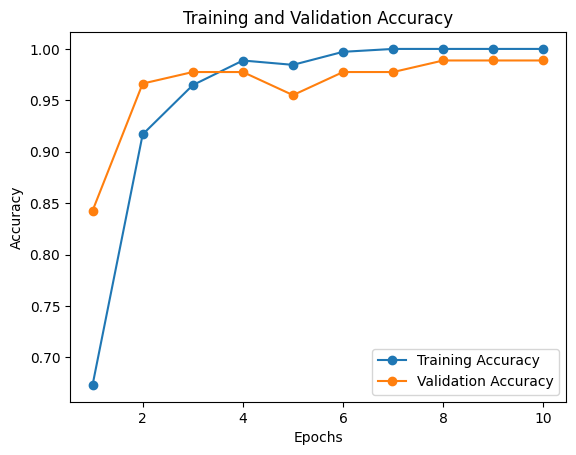

In [26]:
import matplotlib.pyplot as plt

# Assuming you have trained your model and have access to the training history
# history = model.fit(...)  # This is where you train your model

# Extract the accuracy and validation accuracy from the history
train_accuracy = hs.history['accuracy']
val_accuracy = hs.history['val_accuracy']

# Create a range of epochs for the x-axis (assuming you have trained for multiple epochs)
epochs = range(1, len(train_accuracy) + 1)

# Plot training accuracy
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o', linestyle='-')

# Plot validation accuracy
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o', linestyle='-')

# Add labels and a legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.title('Training and Validation Accuracy')
plt.show()


# **Plotting Loss-Validation loss**

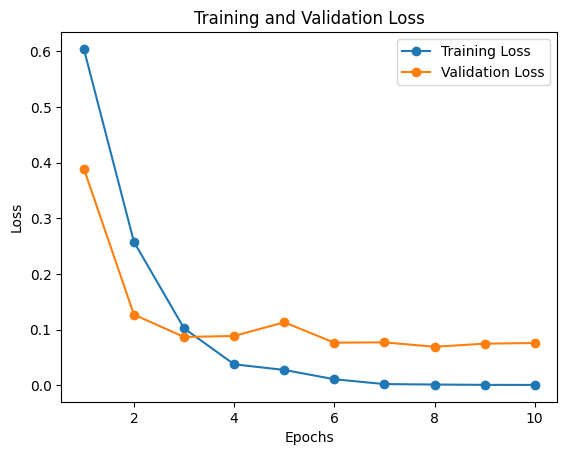

In [27]:
# Assuming you have trained your model and have access to the training history
# history = model.fit(...)  # This is where you train your model

# Extract the loss and validation loss from the history
train_loss = hs.history['loss']
val_loss = hs.history['val_loss']

# Create a range of epochs for the x-axis (assuming you have trained for multiple epochs)
epochs = range(1, len(train_loss) + 1)

# Plot training loss
plt.plot(epochs, train_loss, label='Training Loss', marker='o', linestyle='-')

# Plot validation loss
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', linestyle='-')

# Add labels and a legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.title('Training and Validation Loss')
plt.show()


#**Testing the model**

1/1 [==============================] - 1s 1s/step


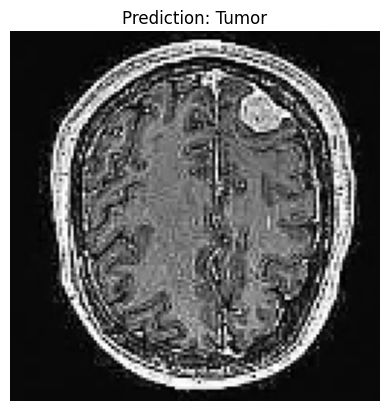

The model predicts that there is a tumor.


In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define image parameters
image_height = 128
image_width = 128
num_channels = 3
sequence_length = 5

# Load and preprocess the single image
image_path = "/content/drive/MyDrive/Colab Notebooks/mri_datasets/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1884).jpg"  # Replace with the path to your image
image = cv2.imread(image_path)
image = cv2.resize(image, (image_width, image_height))
image = image.astype(np.float32) / 255.0  # Normalize pixel values


sequence_image = np.array([image] * sequence_length)


sequence_image = sequence_image.reshape(1, sequence_length, image_height, image_width, num_channels)


predictions = model.predict(sequence_image)

threshold = 0.5
is_tumor = predictions[0][0] > threshold

# Display the image along with the prediction
plt.imshow(image)
if is_tumor:
    plt.title("Prediction: Tumor")
else:
    plt.title("Prediction: No Tumor")
plt.axis('off')
plt.show()

# Print the prediction result
if is_tumor:
    print("The model predicts that there is a tumor.")
else:
    print("The model predicts that there is no tumor.")

